In [136]:
# multivariate output data prep
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
#import preprocessing

In [137]:
np.random.seed(7)

In [138]:
# IMPORTING DATASET 
#dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
#dataset = pd.read_csv('Stock_with_label.csv', usecols=[1,2,3,4,5])
#dataset = pd.read_csv('Stock_with_label_sa.csv', usecols=[1,2,3,4,5])
#dataset = pd.read_csv('AE_MSFT_SA.csv', usecols=[1,2,3,4,5])
dataset = pd.read_csv('Stock_new_with_AELabel.csv', usecols=[1,2,3,4,5])
dataset = dataset.reindex(index = dataset.index[::-1])
print(dataset)
dataset.shape
dataset = dataset.values #return the numpy representation of the given DataFrame.
dataset = dataset.astype('float32')

           Open       High        Low      Close  Label
4150  51.286648  51.855648  50.729305  51.301525      1
4149  50.794872  51.421833  50.318756  50.947674      1
4148  50.077830  50.714893  49.619500  50.261810      1
4147  48.970596  49.588543  48.528996  49.148100      1
4146  48.707577  49.233883  48.141827  48.621273      0
4145  49.977596  50.561210  49.408546  49.973087      0
4144  51.435030  52.087368  50.964630  51.622590      1
4143  51.163000  51.717495  50.603836  51.160260      0
4142  50.496098  51.175920  50.051582  50.743553      1
4141  50.477886  51.001820  49.880820  50.379395      1
4140  50.214535  50.765488  49.677475  50.211900      0
4139  49.767124  50.418713  49.330270  49.997025      1
4138  49.869860  50.406700  49.325650  49.866394      0
4137  49.853405  50.408770  49.331833  49.882534      0
4136  49.637104  50.300713  49.168870  49.810375      0
4135  51.308537  51.930440  50.787857  51.413754      0
4134  51.839962  52.389340  51.266838  51.805050

In [139]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [140]:
# split into train and test sets
train_size = int(len(dataset) * 0.80) #1114
test_size = len(dataset) - train_size #550
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train.shape) # (1114,4)
print(test.shape) #(550,4)

(3320, 5)
(831, 5)


In [141]:
# split a multivariate sequence into samples
def create_dataset(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [142]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3318, 2, 5)
(3318, 5)
(829, 2, 5)
(829, 5)


In [143]:
print(trainX)

[[[0.8489531  0.8457913  0.84807825 0.84761524 1.        ]
  [0.8373858  0.83572763 0.8383192  0.8393028  1.        ]]

 [[0.8373858  0.83572763 0.8383192  0.8393028  1.        ]
  [0.8205197  0.8193279  0.8216975  0.8231909  1.        ]]

 [[0.8205197  0.8193279  0.8216975  0.8231909  1.        ]
  [0.79447544 0.79319876 0.79577565 0.7970284  1.        ]]

 ...

 [[0.24859288 0.24853367 0.24934924 0.25057587 0.        ]
  [0.24355283 0.24300146 0.24392658 0.24442449 0.        ]]

 [[0.24355283 0.24300146 0.24392658 0.24442449 0.        ]
  [0.24391821 0.24283206 0.24368459 0.2433097  1.        ]]

 [[0.24391821 0.24283206 0.24368459 0.2433097  1.        ]
  [0.25204095 0.25063825 0.25140113 0.25090614 1.        ]]]


In [144]:
print(trainY)

[[0.8205197  0.8193279  0.8216975  0.8231909  1.        ]
 [0.79447544 0.79319876 0.79577565 0.7970284  1.        ]
 [0.78828883 0.7849713  0.78657234 0.7846526  0.        ]
 ...
 [0.24391821 0.24283206 0.24368459 0.2433097  1.        ]
 [0.25204095 0.25063825 0.25140113 0.25090614 1.        ]
 [0.24215457 0.24182087 0.24272531 0.24364665 0.        ]]


In [145]:
print(testX)

[[[0.23863992 0.2371884  0.23801339 0.2375786  0.        ]
  [0.24174109 0.24058688 0.24170303 0.24163404 1.        ]]

 [[0.24174109 0.24058688 0.24170303 0.24163404 1.        ]
  [0.24686947 0.24580878 0.24679685 0.24668702 1.        ]]

 [[0.24686947 0.24580878 0.24679685 0.24668702 1.        ]
  [0.23611161 0.23654193 0.23743218 0.23913512 0.        ]]

 ...

 [[0.9240775  0.9257235  0.9266212  0.9308139  1.        ]
  [0.9484328  0.9453444  0.94466996 0.94197774 1.        ]]

 [[0.9484328  0.9453444  0.94466996 0.94197774 1.        ]
  [0.9551177  0.95741683 0.9565823  0.9608023  0.        ]]

 [[0.9551177  0.95741683 0.9565823  0.9608023  0.        ]
  [0.98209715 0.9787739  0.9780433  0.9764279  0.        ]]]


In [146]:
print(testY)

[[0.24686947 0.24580878 0.24679685 0.24668702 1.        ]
 [0.23611161 0.23654193 0.23743218 0.23913512 0.        ]
 [0.23994747 0.23823303 0.23908341 0.2380198  1.        ]
 ...
 [0.9551177  0.95741683 0.9565823  0.9608023  0.        ]
 [0.98209715 0.9787739  0.9780433  0.9764279  0.        ]
 [0.9999999  1.         1.         1.0000001  0.        ]]


In [147]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils.vis_utils import plot_model
# define model
n_features = trainX.shape[2]
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(look_back, n_features)))
model.add(GRU(256, return_sequences=False))
model.add(Dropout(0.2))
#model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='sgd', loss='mae')
model.summary()


# n_features = trainX.shape[2]
# model = Sequential()
# model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
# model.add(LSTM(256, activation='relu'))
# model.add(Dropout(0.2))
# #model.add(LSTM(100, activation='relu'))
# model.add(Dense(n_features))
# model.compile(optimizer='adam', loss='mse')
# model.summary()
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 2, 100)            31800     
_________________________________________________________________
gru_6 (GRU)                  (None, 256)               274176    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 307,261
Trainable params: 307,261
Non-trainable params: 0
_________________________________________________________________


In [148]:
#tensorboard = TensorBoard(log_dir='./logs/run1/', write_graph=True, write_images=False)
#tensorboard = TensorBoard(log_dir='/home/user/Python_docs_rks/LSTM_prediction/LSTM_SABU_SIR/SABU_SIR_26-04-2020/logs/run1/',write_graph=True, write_images=False)
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode=min)
#model_file = "/home/sabu/Desktop/weights/best_model.hdf5"
#model_file = "/home/user/Python_docs_rks/LSTM_prediction/LSTM_SABU_SIR/weights/best_model.hdf5"
#checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [149]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=32, verbose=2)#, callbacks=[tensorboard, early_stop, checkpoint])

Train on 3318 samples, validate on 829 samples
Epoch 1/100
 - 2s - loss: 0.2535 - val_loss: 0.1867
Epoch 2/100
 - 1s - loss: 0.2011 - val_loss: 0.1821
Epoch 3/100
 - 1s - loss: 0.1953 - val_loss: 0.1771
Epoch 4/100
 - 1s - loss: 0.1897 - val_loss: 0.1722
Epoch 5/100
 - 1s - loss: 0.1830 - val_loss: 0.1679
Epoch 6/100
 - 1s - loss: 0.1759 - val_loss: 0.1602
Epoch 7/100
 - 1s - loss: 0.1677 - val_loss: 0.1541
Epoch 8/100
 - 1s - loss: 0.1585 - val_loss: 0.1449
Epoch 9/100
 - 1s - loss: 0.1482 - val_loss: 0.1346
Epoch 10/100
 - 1s - loss: 0.1370 - val_loss: 0.1244
Epoch 11/100
 - 1s - loss: 0.1266 - val_loss: 0.1169
Epoch 12/100
 - 1s - loss: 0.1208 - val_loss: 0.1130
Epoch 13/100
 - 1s - loss: 0.1174 - val_loss: 0.1123
Epoch 14/100
 - 1s - loss: 0.1166 - val_loss: 0.1124
Epoch 15/100
 - 1s - loss: 0.1160 - val_loss: 0.1128
Epoch 16/100
 - 1s - loss: 0.1150 - val_loss: 0.1129
Epoch 17/100
 - 1s - loss: 0.1147 - val_loss: 0.1134
Epoch 18/100
 - 1s - loss: 0.1141 - val_loss: 0.1135
Epoch 19

In [150]:
history_dict = history.history
loss = history_dict['loss']
#val_loss = history_dict['val_loss']
print(history_dict.keys())

dict_keys(['val_loss', 'loss'])


No handles with labels found to put in legend.


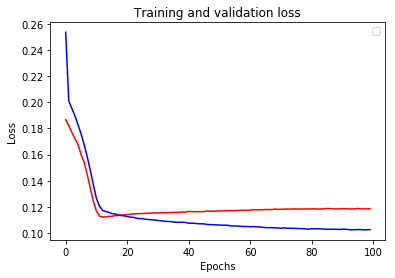

In [151]:
import matplotlib
#plt.plot(ae.history.history['val_loss'], 'r', ae.history.history['loss'], 'b')
plt.plot(model.history.history['val_loss'], 'r',model.history.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [152]:
trainPredict = model.predict(trainX)
yhat = model.predict(testX, verbose=1)
print(yhat)

829/829 [==============================] - 0s 119us/step
[[0.23859286 0.23533173 0.23569149 0.23689796 0.9826431 ]
 [0.2388418  0.23570651 0.23644456 0.23789589 0.97295326]
 [0.24167685 0.23896907 0.23885077 0.24083456 0.97989094]
 ...
 [0.9171703  0.91261005 0.9164535  0.91850525 0.9504912 ]
 [0.93871355 0.9327095  0.936249   0.938728   0.95682627]
 [0.96087694 0.9541611  0.95755434 0.9597867  0.96514976]]


In [153]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(yhat)
testY = scaler.inverse_transform(testY)

In [154]:
print(trainPredict)

[[50.45299    50.964645   49.892635   50.55004     0.9535109 ]
 [49.916973   50.426735   49.35898    50.007786    0.95390904]
 [49.056755   49.558292   48.503185   49.13798     0.9546022 ]
 ...
 [25.828182   26.064934   25.450184   25.800068    0.9892689 ]
 [25.508307   25.714506   25.134464   25.472294    0.98250496]
 [25.492111   25.699482   25.141722   25.492153    0.97285044]]


In [155]:
print(trainPredict.shape)

(3318, 5)


In [156]:
print(trainY)

[[50.077835 50.714893 49.6195   50.26181   1.      ]
 [48.970596 49.588547 48.529    49.1481    1.      ]
 [48.70758  49.233883 48.141827 48.621277  0.      ]
 ...
 [25.564335 25.863918 25.303177 25.576916  1.      ]
 [25.909664 26.200418 25.627802 25.900288  1.      ]
 [25.489357 25.82033  25.262821 25.59126   0.      ]]


In [157]:
print(trainY.shape)

(3318, 5)


In [158]:
print(testPredict)

[[25.337936   25.540602   24.966917   25.303976    0.9826431 ]
 [25.348518   25.556757   24.998598   25.346457    0.97295326]
 [25.469046   25.697397   25.099825   25.471552    0.97989094]
 ...
 [54.186813   54.736004   53.605774   54.319237    0.9504912 ]
 [55.1027     55.60243    54.438545   55.18009     0.95682627]
 [56.04495    56.52714    55.334835   56.07654     0.96514976]]


In [159]:
print(testPredict.shape)

(829, 5)


In [160]:
print(testY)

[[25.689804 25.992235 25.434107 25.720686  1.      ]
 [25.232447 25.59277  25.040146 25.399208  0.      ]
 [25.395525 25.665668 25.109612 25.35173   1.      ]
 ...
 [55.800102 56.667484 55.293945 56.11977   0.      ]
 [56.947098 57.588123 56.196785 56.784935  0.      ]
 [57.70821  58.503117 57.120476 57.78838   0.      ]]


In [161]:
print(testY.shape)

(829, 5)


In [162]:
original = (scaler.inverse_transform(train))
#print(scaler.inverse_transform(train))
print(original)

[[51.286648 51.855648 50.729305 51.301525  1.      ]
 [50.794876 51.421833 50.318752 50.947674  1.      ]
 [50.077835 50.714893 49.6195   50.26181   1.      ]
 ...
 [25.564335 25.863918 25.303177 25.576916  1.      ]
 [25.909664 26.200418 25.627802 25.900288  1.      ]
 [25.489357 25.82033  25.262821 25.59126   0.      ]]


In [163]:
Opentrain = original
print(Opentrain[:,:1])
print(Opentrain.shape)


[[51.286648]
 [50.794876]
 [50.077835]
 ...
 [25.564335]
 [25.909664]
 [25.489357]]
(3320, 5)


In [164]:
Hightrain = original
print(Hightrain[:,1:2])

[[51.855648]
 [51.421833]
 [50.714893]
 ...
 [25.863918]
 [26.200418]
 [25.82033 ]]


In [165]:
Lowtrain = original
print(Lowtrain[:,2:3])

[[50.729305]
 [50.318752]
 [49.6195  ]
 ...
 [25.303177]
 [25.627802]
 [25.262821]]


In [166]:
Closetrain = original
print(Closetrain[:,3:4])

[[51.301525]
 [50.947674]
 [50.26181 ]
 ...
 [25.576916]
 [25.900288]
 [25.59126 ]]


In [167]:
original_test = (scaler.inverse_transform(test))
print(scaler.inverse_transform(test))
print(original_test)
print(original_test.shape)

[[25.339935 25.620638 25.064596 25.33295   0.      ]
 [25.471777 25.767136 25.219816 25.505585  1.      ]
 [25.689804 25.992235 25.434107 25.720686  1.      ]
 ...
 [55.800102 56.667484 55.293945 56.11977   0.      ]
 [56.947098 57.588123 56.196785 56.784935  0.      ]
 [57.70821  58.503117 57.120476 57.78838   0.      ]]
[[25.339935 25.620638 25.064596 25.33295   0.      ]
 [25.471777 25.767136 25.219816 25.505585  1.      ]
 [25.689804 25.992235 25.434107 25.720686  1.      ]
 ...
 [55.800102 56.667484 55.293945 56.11977   0.      ]
 [56.947098 57.588123 56.196785 56.784935  0.      ]
 [57.70821  58.503117 57.120476 57.78838   0.      ]]
(831, 5)


In [168]:
Opentest = original_test
#print(Opentest[:,:1])
print(Opentest.shape)

(831, 5)


In [169]:
Hightest = original_test
#print(Hightest[:,1:2])

In [170]:
Lowtest = original_test
#print(Lowtest[:,2:3])

In [171]:
Closetest = original_test
#print(Closetest[:,3:4])

In [172]:
print(trainPredict)

[[50.45299    50.964645   49.892635   50.55004     0.9535109 ]
 [49.916973   50.426735   49.35898    50.007786    0.95390904]
 [49.056755   49.558292   48.503185   49.13798     0.9546022 ]
 ...
 [25.828182   26.064934   25.450184   25.800068    0.9892689 ]
 [25.508307   25.714506   25.134464   25.472294    0.98250496]
 [25.492111   25.699482   25.141722   25.492153    0.97285044]]


In [173]:
OpentrainPredict = trainPredict
print(OpentrainPredict[:,:1])

[[50.45299 ]
 [49.916973]
 [49.056755]
 ...
 [25.828182]
 [25.508307]
 [25.492111]]


In [174]:
HightrainPredict = trainPredict
print(HightrainPredict[:,1:2])

[[50.964645]
 [50.426735]
 [49.558292]
 ...
 [26.064934]
 [25.714506]
 [25.699482]]


In [175]:
LowtrainPredict = trainPredict
print(LowtrainPredict[:,2:3])

[[49.892635]
 [49.35898 ]
 [48.503185]
 ...
 [25.450184]
 [25.134464]
 [25.141722]]


In [176]:
ClosetrainPredict = trainPredict
print(ClosetrainPredict[:,3:4])

[[50.55004 ]
 [50.007786]
 [49.13798 ]
 ...
 [25.800068]
 [25.472294]
 [25.492153]]


In [177]:
OpentestPredict = testPredict
#print(OpentestPredict[:,:1])

In [178]:
HightestPredict = testPredict
#print(HightestPredict[:,1:2])

In [179]:
LowtestPredict = testPredict
#print(LowtestPredict[:,2:3])

In [180]:
ClosetestPredict = testPredict
#print(ClosetestPredict[:,3:4])

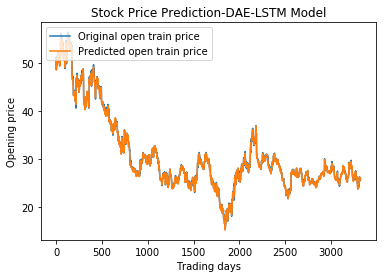

In [181]:
# # shift opentrain predictions for plotting
OpentrainPlot = np.empty_like(Opentrain[:,:1])
OpentrainPlot = Opentrain[:,:1]
# shift OpentrainPredict predictions for plotting
OpentrainPredictPlot = np.empty_like(OpentrainPredict[:,:1])
OpentrainPredictPlot = OpentrainPredict[:,:1]
# # plot baseline and predictions
plt.plot(OpentrainPlot, '', label='Original open train price' )
plt.plot(OpentrainPredictPlot, '', label='Predicted open train price' )
plt.ylabel('Opening price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

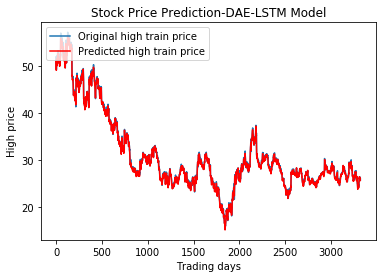

In [182]:
# # shift Hightrain predictions for plotting
HightrainPlot = np.empty_like(Hightrain[:,1:2])
HightrainPlot = Hightrain[:,1:2]
# shift HightrainPredict predictions for plotting
HightrainPredictPlot = np.empty_like(HightrainPredict[:,1:2])
HightrainPredictPlot = HightrainPredict[:,1:2]
# # plot baseline and predictions
plt.plot(HightrainPlot, '', label='Original high train price' )
plt.plot(HightrainPredictPlot, 'r', label='Predicted high train price' )
plt.ylabel('High price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

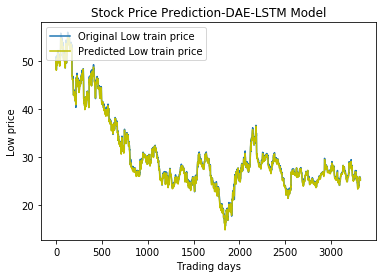

In [183]:
# # shift Lowtrain predictions for plotting
LowtrainPlot = np.empty_like(Lowtrain[:,2:3])
LowtrainPlot = Lowtrain[:,2:3]
# shift LowtrainPredict predictions for plotting
LowtrainPredictPlot = np.empty_like(LowtrainPredict[:,2:3])
LowtrainPredictPlot = LowtrainPredict[:,2:3]
# # plot baseline and predictions
plt.plot(LowtrainPlot, '', label='Original Low train price' )
plt.plot(LowtrainPredictPlot, 'y', label='Predicted Low train price' )
plt.ylabel('Low price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

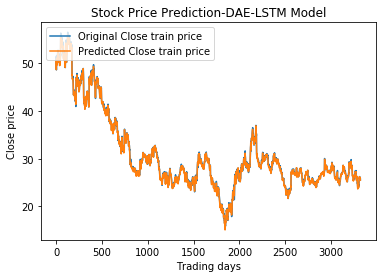

In [184]:
# # shift Closetrain predictions for plotting
ClosetrainPlot = np.empty_like(Closetrain[:,3:4])
ClosetrainPlot = Hightrain[:,3:4]
# shift ClosetrainPredict predictions for plotting
ClosetrainPredictPlot = np.empty_like(ClosetrainPredict[:,3:4])
ClosetrainPredictPlot = ClosetrainPredict[:,3:4]
# # plot baseline and predictions
plt.plot(ClosetrainPlot, '', label='Original Close train price' )
plt.plot(ClosetrainPredictPlot, '', label='Predicted Close train price' )
plt.ylabel('Close price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

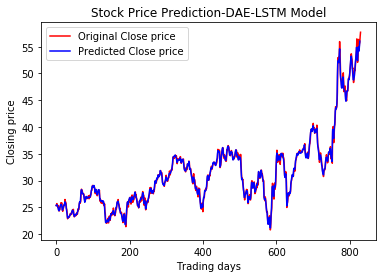

In [185]:

# shift OpentestPredict predictions for plotting
OpentestPlot = np.empty_like(Opentrain[:,:1])
OpentestPlot = Opentest[:,:1]
# shift OpentestPredict predictions for plotting
OpentestPredictPlot = np.empty_like(OpentestPredict[:,:1])
OpentestPredictPlot = OpentestPredict[:,:1]
# # plot baseline and predictions
plt.plot(OpentestPlot, 'r', label='Original Close price' )
plt.plot(OpentestPredictPlot, 'b', label='Predicted Close price' )
plt.ylabel('Closing price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

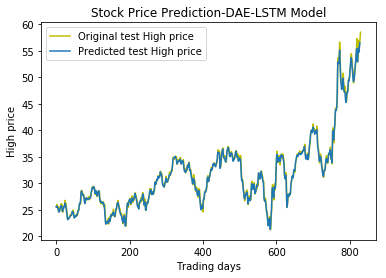

In [186]:
# shift Hightest predictions for plotting
HightestPlot = np.empty_like(Hightest[:,1:2])
HightestPlot = Hightest[:,1:2]
# shift HightestPredict predictions for plotting
HightestPredictPlot = np.empty_like(HightestPredict[:,1:2])
HightestPredictPlot = HightestPredict[:,1:2]
# # plot baseline and predictions
plt.plot(HightestPlot, 'y', label='Original test High price' )
plt.plot(HightestPredictPlot, '', label='Predicted test High price' )
plt.ylabel('High price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

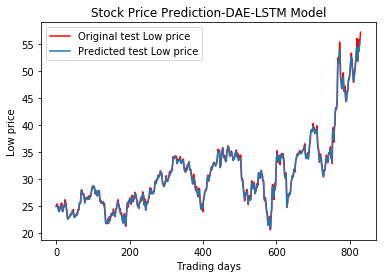

In [187]:
# shift Lowtest predictions for plotting
LowtestPlot = np.empty_like(Lowtest[:,2:3])
LowtestPlot = Lowtest[:,2:3]
# shift LowtrainPredict predictions for plotting
LowtestPredictPlot = np.empty_like(LowtestPredict[:,2:3])
LowtestPredictPlot = LowtestPredict[:,2:3]
# # plot baseline and predictions
plt.plot(LowtestPlot, 'r', label='Original test Low price' )
plt.plot(LowtestPredictPlot, '', label='Predicted test Low price' )
plt.ylabel('Low price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-LSTM Model')
plt.show()

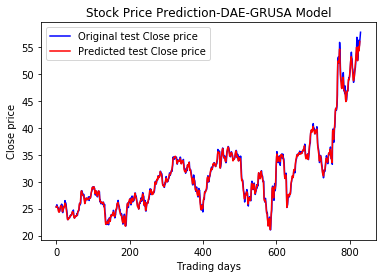

In [188]:
# shift Closetest predictions for plotting
ClosetestPlot = np.empty_like(Closetest[:,3:4])
ClosetestPlot = Closetest[:,3:4]
# shift ClosetrainPredict predictions for plotting
ClosetestPredictPlot = np.empty_like(ClosetestPredict[:,3:4])
ClosetestPredictPlot = ClosetestPredict[:,3:4]
# # plot baseline and predictions
plt.plot(ClosetestPlot, 'b', label='Original test Close price' )
plt.plot(ClosetestPredictPlot, 'r', label='Predicted test Close price' )
plt.ylabel('Close price')
plt.xlabel("Trading days")
plt.legend(loc='upper left')
plt.title('Stock Price Prediction-DAE-GRUSA Model')
plt.show()

In [189]:
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY, testPredict))
# print('Test Score: %.2f RMSE' % (testScore))

In [190]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,:-1], trainPredict[:,:-1]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,:-1], testPredict[:,:-1]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.51 RMSE
Test Score: 0.95 RMSE


In [191]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [192]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

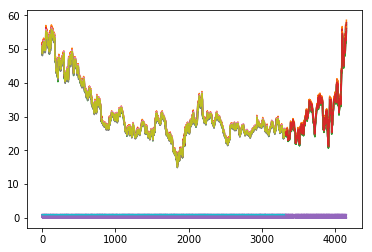

In [193]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [194]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1,:]
print(last_val)
last_val_scaled = last_val/last_val
print(last_val_scaled)


[56.04495    56.52714    55.334835   56.07654     0.96514976]
[1. 1. 1. 1. 1.]


In [195]:
yy = yhat[-2:,:]
yy=yy.reshape((-1,2,5))
print(np.shape(yy))
#print(yy)
nexty = model.predict(yy)
print(nexty)

(1, 2, 5)
[[0.9282428  0.92399186 0.92753553 0.92976964 0.9509996 ]]


In [196]:
actualnexty = scaler.inverse_transform(nexty)
print(actualnexty)

[[54.657547  55.226635  54.07198   54.798744   0.9509996]]


In [197]:
period = 4
yresult = []
yy = yhat[-2:,:]
#yy=yy.reshape((-1,2,4))
for i in range(period):
    yy=yy.reshape((-1,2,5))
    nexty = model.predict(yy)
    #print(nexty)
    actualnexty = scaler.inverse_transform(nexty)
    #print(actualnexty)
    yresult.append(actualnexty[0].tolist())
    yy = yy[0]
    #print(yy)
    yy=np.delete(yy,0,axis=0)
    #print(ary)
    yy=np.insert(yy,1,nexty[0],axis=0)
    #print(yy)
for y in yresult:
    print(y)

[54.65754699707031, 55.22663497924805, 54.07197952270508, 54.798744201660156, 0.9509996175765991]
[54.510013580322266, 55.086204528808594, 53.9129753112793, 54.61867141723633, 0.9511972069740295]
[53.81081771850586, 54.371150970458984, 53.2236213684082, 53.9281005859375, 0.9517579674720764]
[53.41809844970703, 53.97490310668945, 52.830928802490234, 53.526126861572266, 0.9520919322967529]


In [198]:
from sklearn.metrics import mean_absolute_error
Train_MAE = mean_absolute_error(trainY[:,:-1], trainPredict[:,:-1])
print(Train_MAE)
Test_MAE = mean_absolute_error(testY[:,:-1], testPredict[:,:-1])
print(Test_MAE)

0.33787784
0.64704835


In [199]:
from sklearn.metrics import r2_score
Train_R2 = r2_score(trainY[:,:-1], trainPredict[:,:-1])
print(Train_R2)
Test_R2 = r2_score(testY[:,:-1], testPredict[:,:-1])
print(Test_R2)

0.996251591737057
0.9825007640579932


In [200]:
#from sklearn.metrics import accuracy_score
#print(accuracy_score(testY, testPredict))

In [201]:
import numpy as np

def mean_absolute_percentage_error_train(trainY, trainPredict): 
    trainY, trainPredict = np.array(trainY[:,:-1]), np.array(trainPredict[:,:-1])
    return np.mean(np.abs((trainY[:,:-1] - trainPredict[:,:-1]) / trainY[:,:-1])) * 100
print(mean_absolute_percentage_error_train(trainY[:,:-1], trainPredict[:,:-1]))

1.1094236746430397


In [202]:
import numpy as np

def mean_absolute_percentage_error_test(testY, testPredict): 
    testY, testPredict = np.array(testY[:,:-1]), np.array(testPredict[:,:-1])
    return np.mean(np.abs((testY[:,:-1] - testPredict[:,:-1]) / testY[:,:-1])) * 100
print(mean_absolute_percentage_error_test(testY[:,:-1], testPredict[:,:-1]))

2.091904915869236
